In [12]:
import numpy as np
import matplotlib.pyplot as plt
import epidemic_model_classes_numba as epi_mod
from data_loading import LoadData 
from proj_consts import ProjectConsts
import pandas as pd
from PIL import Image
import time
import os

log_path = "../logs/log2021-02-09_20-05-55/"

data_path = open("data_path.txt", "r").read()
df_brazil_state_cases = pd.read_csv(data_path)

# pop_state_dat = open(f"{ProjectConsts.DATA_PATH}/pop_states.csv", "r").read().split("\n")
# pop_state = {}
# for i in range(len(pop_state_dat)-1):
#     pop_state_dat[i] = pop_state_dat[i].split(", ")
#     pop_state[pop_state_dat[i][0]] = int(pop_state_dat[i][1])

In [13]:
locations = open(r"locationsIN.txt", "r").read().split("\n")[:-1]
# models = open(r"modelsIN.txt", "r").read().split("\n")[:1]
models = ["SEIRD2"]#, "SEIHRD", "SEIARD"]
print(locations)
print(models)

['DF']
['SEIRD2']


In [14]:
data = LoadData.getBrazilStateDataFrame(df_brazil_state_cases, locations[0])

In [15]:
n_post = 0
for file in os.listdir(log_path):
    
    if ("Posterior" in file):
        n_post += 1
        
print(n_post)

3


In [16]:
location = locations[0]

days_sets = sorted(os.listdir(log_path+"Posterior1/%s/%s/"%(location, models[0])), key=lambda x: int(x.split("_")[0]))[:-1]
n_days = len(days_sets)

days = []

for days_set in days_sets:
    
    days.append(int(days_set.split("_")[0]))

days = np.array(days)

In [17]:
rmsd_train = np.zeros((len(models), n_post, n_days))
rmsd_val= np.zeros((len(models), n_post, n_days))
rmsd_total = np.zeros((len(models), n_post, n_days))

params = []

for model_idx in range(len(models)):
    
    model = getattr(epi_mod, models[model_idx])
        
    params.append(np.zeros((n_post, n_days, model.nparams)))
    
    for post in range(1, n_post+1):
            
        path = log_path+"Posterior%i/%s/%s/" % (post, location, models[model_idx])
        
        for days_idx in range(len(days_sets)):
            
            params[-1][post-1,days_idx,:] = np.genfromtxt(path+days_sets[days_idx]+"/best_params.txt")
            
            log_file = open(path+days_sets[days_idx]+"/%s_log.out"%model.name).read().split("\n")[:-1]
            
            for line in range(len(log_file)):

                if ("RMSD:" in log_file[line]):

                    rmsd_start_line = line
            
            rmsd_train[model_idx, post-1, days_idx] = float(log_file[rmsd_start_line].split(" ")[-1])/data.confirmed.values[days[days_idx]-1]
            rmsd_val[model_idx, post-1, days_idx] = float(log_file[rmsd_start_line+1].split(" ")[-1])/data.confirmed.values[days[days_idx]-1]
            rmsd_total[model_idx, post-1, days_idx] = float(log_file[rmsd_start_line+2].split(" ")[-1])/data.confirmed.values[days[days_idx]-1]

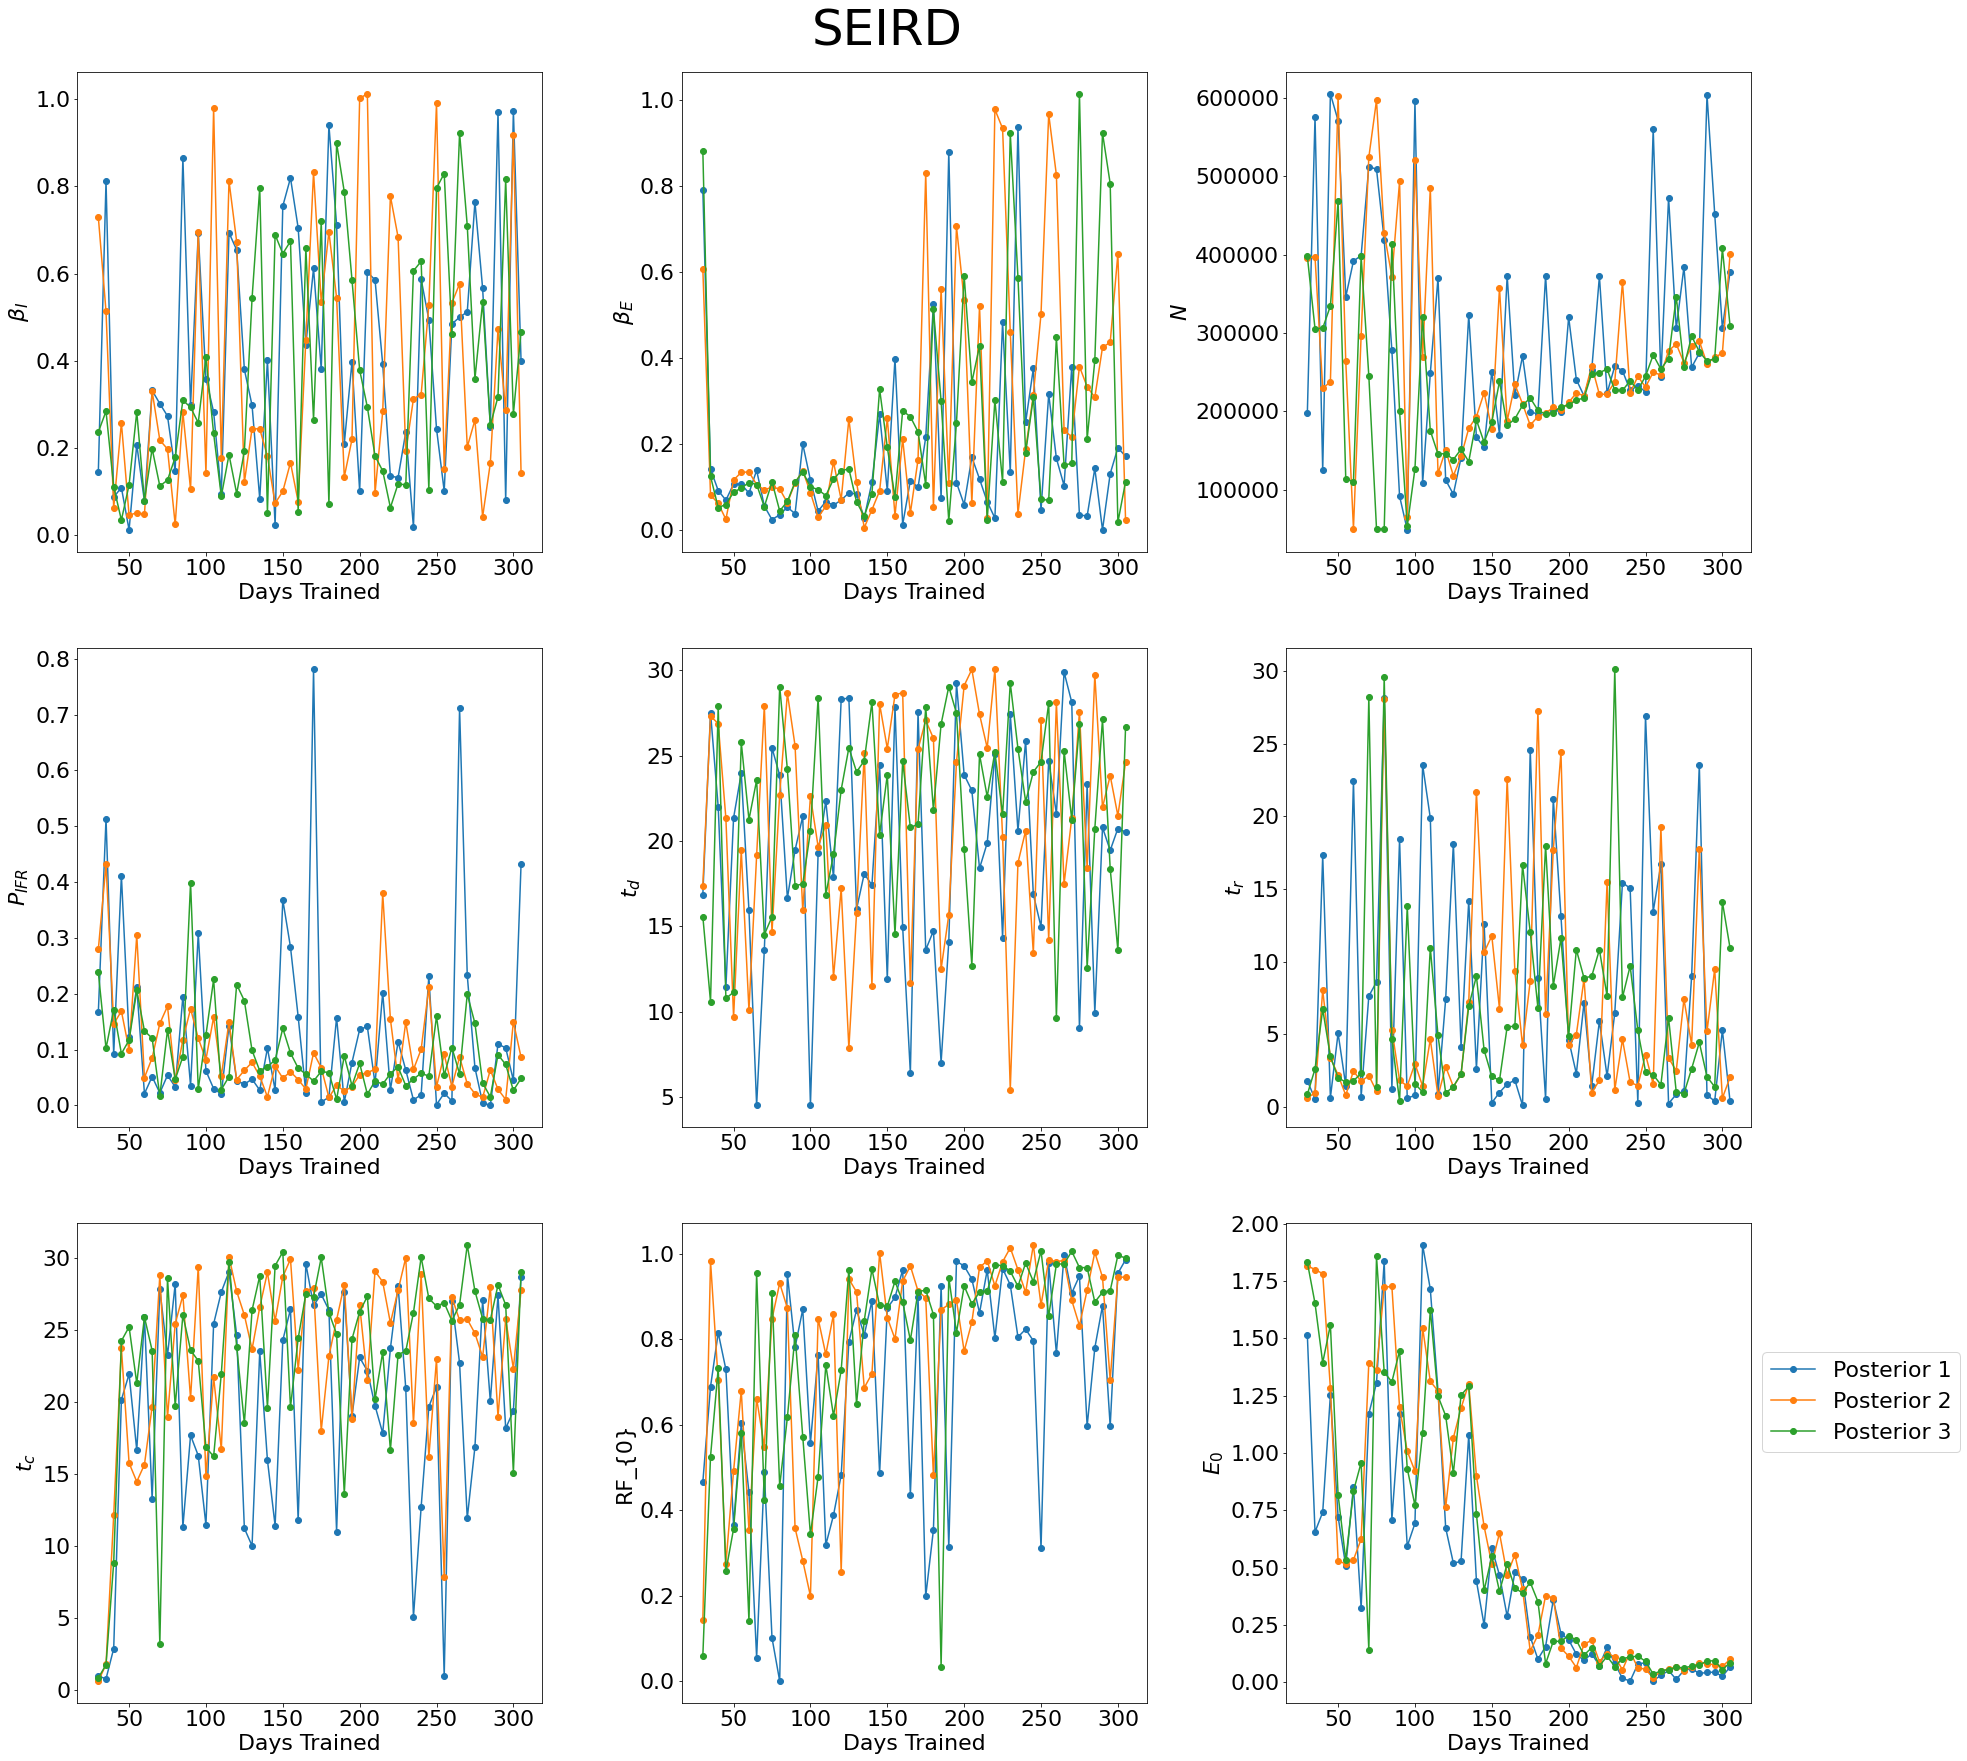

In [18]:
plt.rcParams.update({'font.size': 22})

def best_rows_cols(n):
    
    rows = 1
    cols = 1
    
    while (rows*cols < n):
        
        if (rows == cols):
            
            cols += 1
            
        else:
            
            rows += 1
            
    return np.array([rows, cols])

for p in range(len(params)):
    
    model = getattr(epi_mod, models[p])
    
    plt.figure(figsize=(10*best_rows_cols(params[p].shape[-1])[::-1]))
    plt.subplots_adjust(wspace=0.3, hspace=0.2)
    
    for i in range(params[p].shape[-1]):

        plt.subplot(*best_rows_cols(params[p].shape[-1]),i+1)
#         plt.figure(figsize=(15,7))
        for j in range(params[p].shape[0]):
            plt.plot(days, params[p][j,:,i], "-o", label="Posterior %i"%(j+1))
        plt.xlabel("Days Trained")
        plt.ylabel(model.params[i])

        if (i == params[p].shape[-1]-1):
            
            plt.legend(bbox_to_anchor=(1, 0.5), loc="lower left")
    
    plt.suptitle(model.plot_name, fontsize=50, y=0.91)
#     plt.savefig("params_evolution_%s.png"%(models[p]), format="png", dpi=300, bbox_inches=None)
    plt.show()

In [19]:
params[p].shape[-1]

9

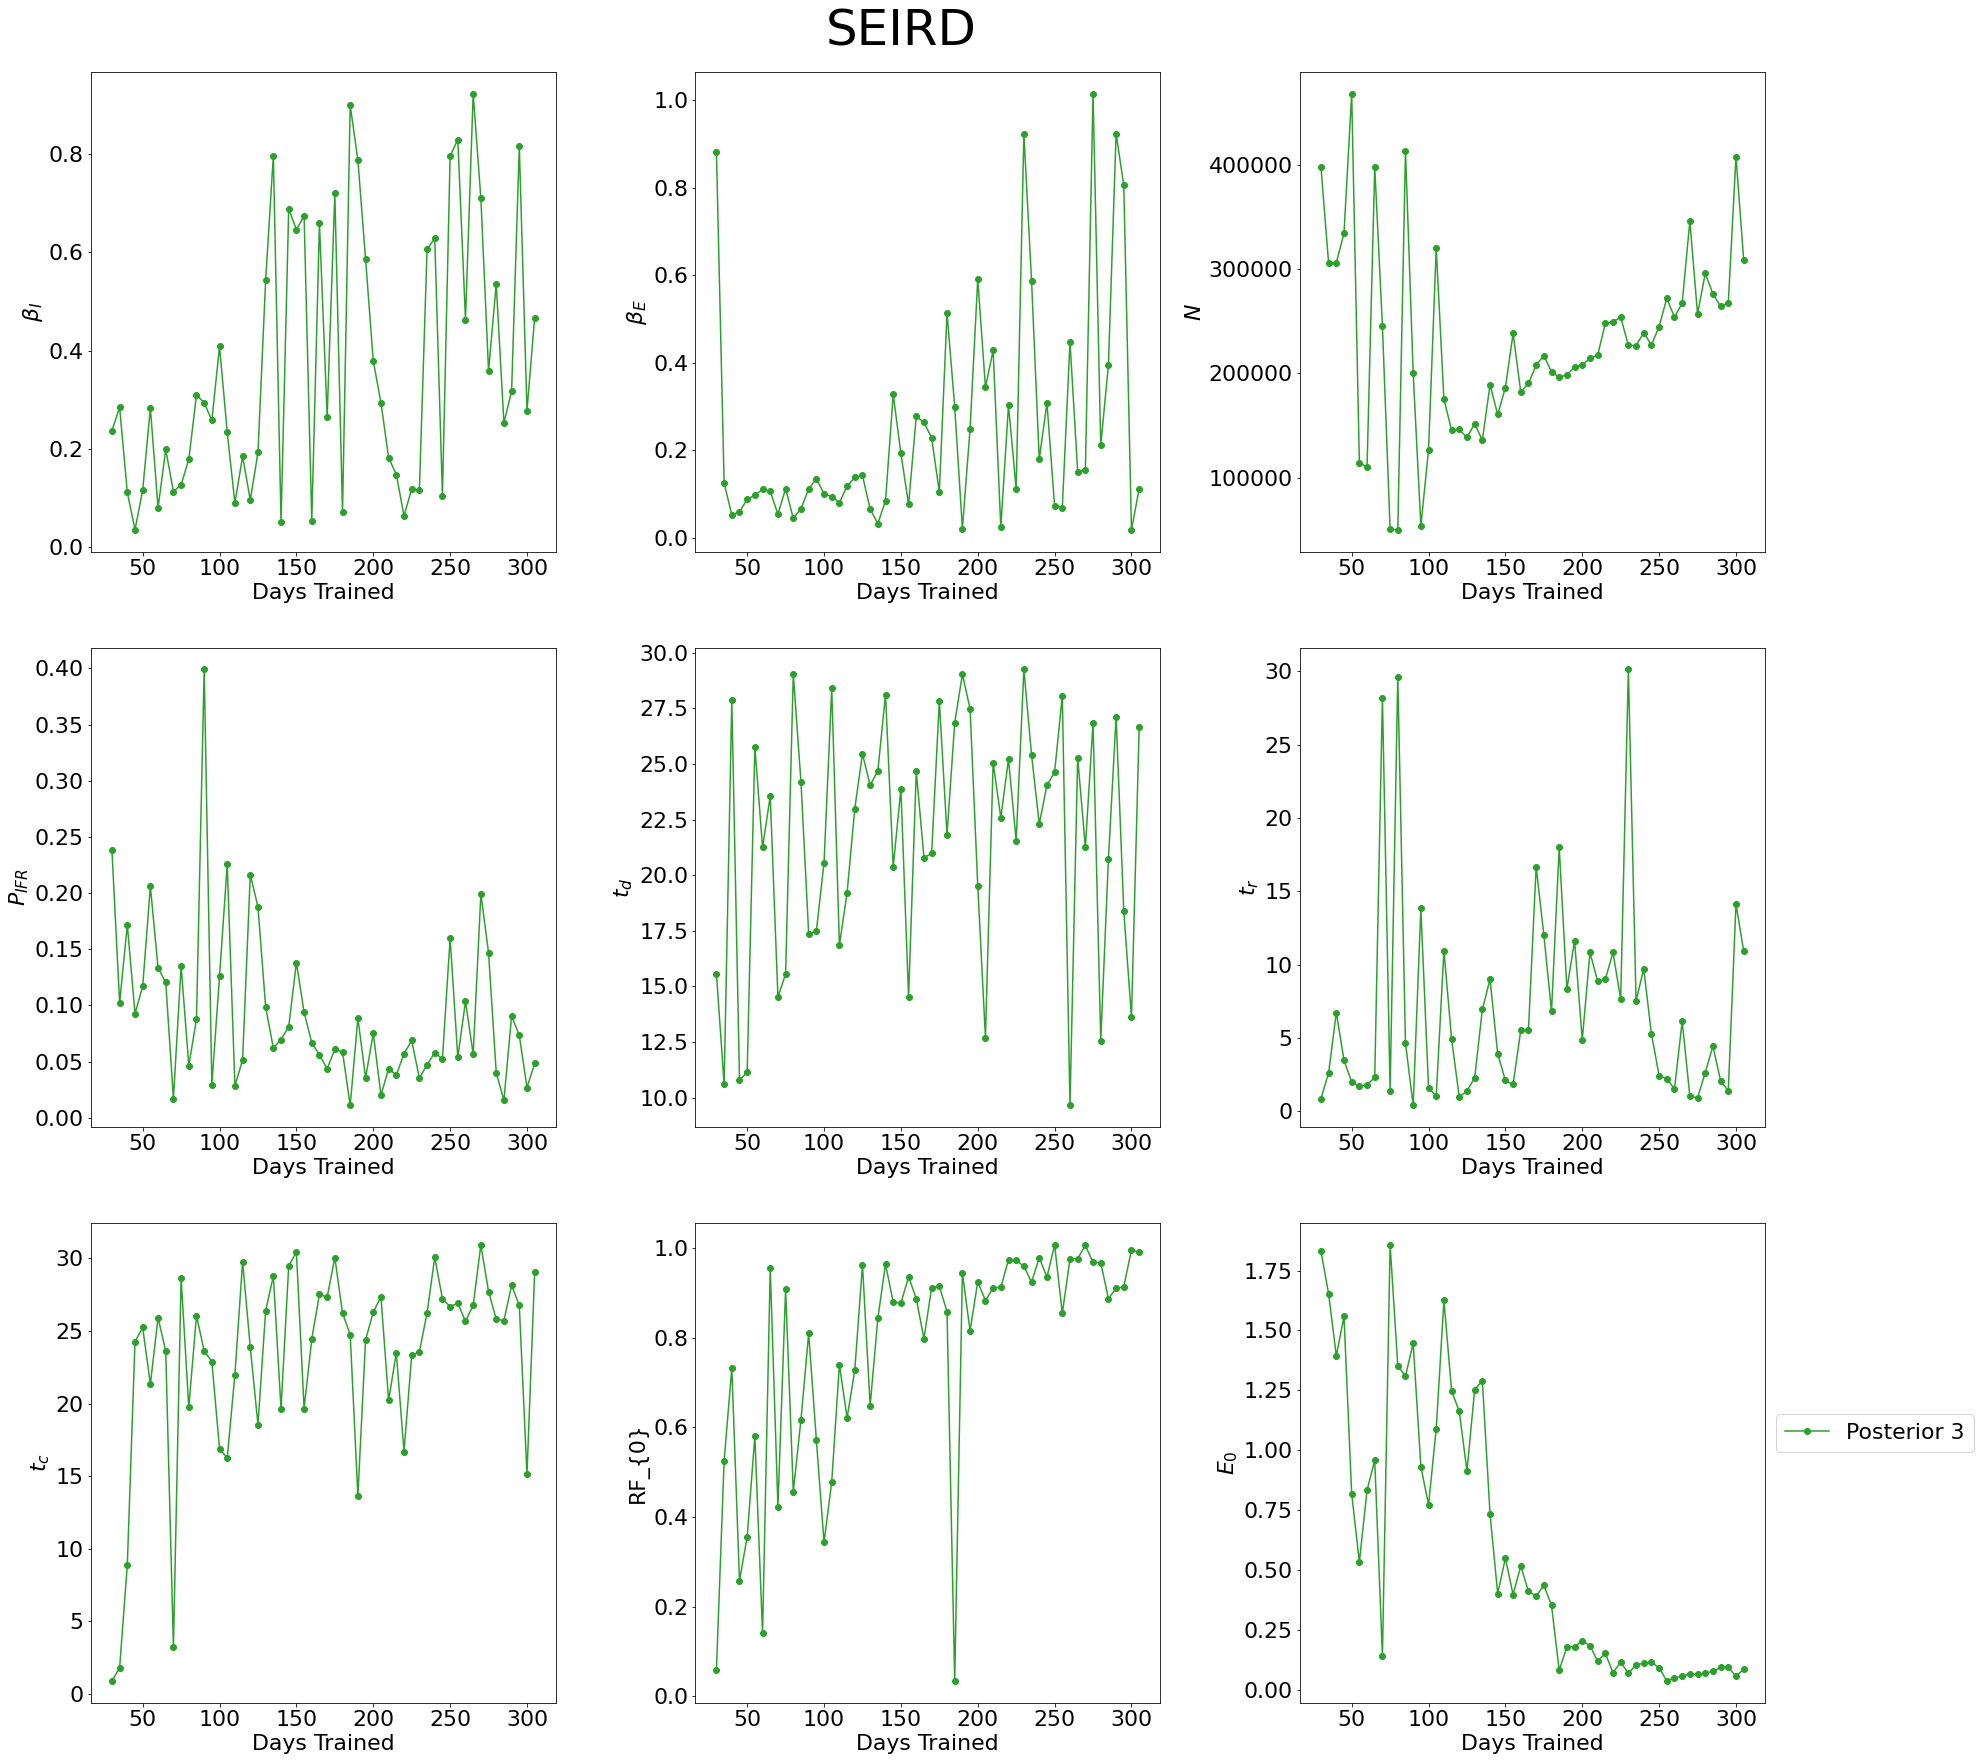

In [20]:
for p in range(len(params)):
    
    model = getattr(epi_mod, models[p])
    
    plt.figure(figsize=(10*best_rows_cols(params[p].shape[-1])[::-1]))
    plt.subplots_adjust(wspace=0.3, hspace=0.2)
    
    for i in range(params[p].shape[-1]):

        plt.subplot(*best_rows_cols(params[p].shape[-1]),i+1)
#         plt.figure(figsize=(15,7))
        plt.plot(days, params[p][-1,:,i], "-o", c="C%s"%(params[p].shape[0]-1), label="Posterior %i"%(params[p].shape[0]))
        plt.xlabel("Days Trained")
        plt.ylabel(model.params[i])

        if (i == params[p].shape[-1]-1):
            
            plt.legend(bbox_to_anchor=(1, 0.5), loc="lower left")
    
    plt.suptitle(model.plot_name, fontsize=50, y=0.91)
#     plt.savefig("params_evolution_%s.png"%(models[p]), format="png", dpi=300, bbox_inches=None)
    plt.show()

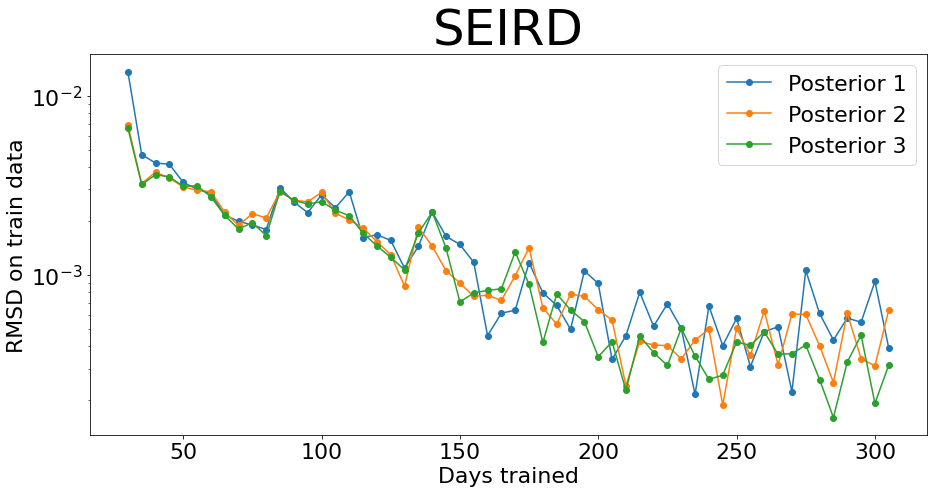

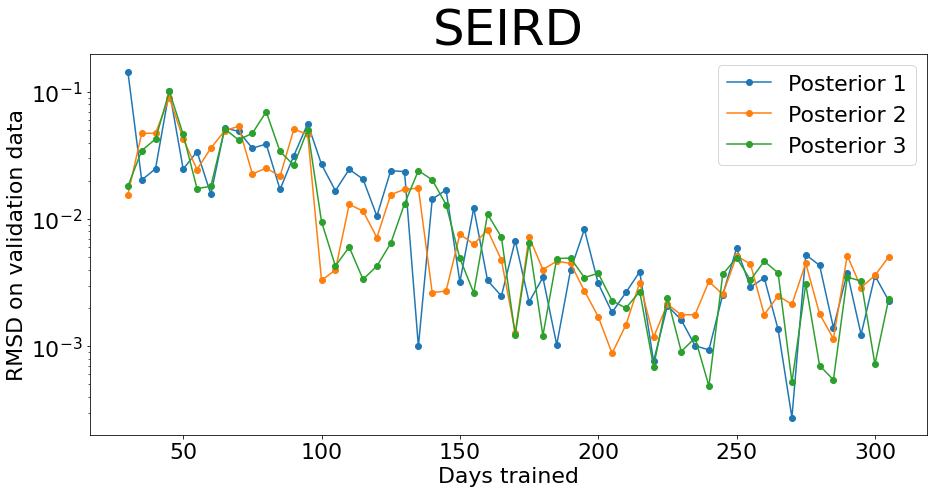

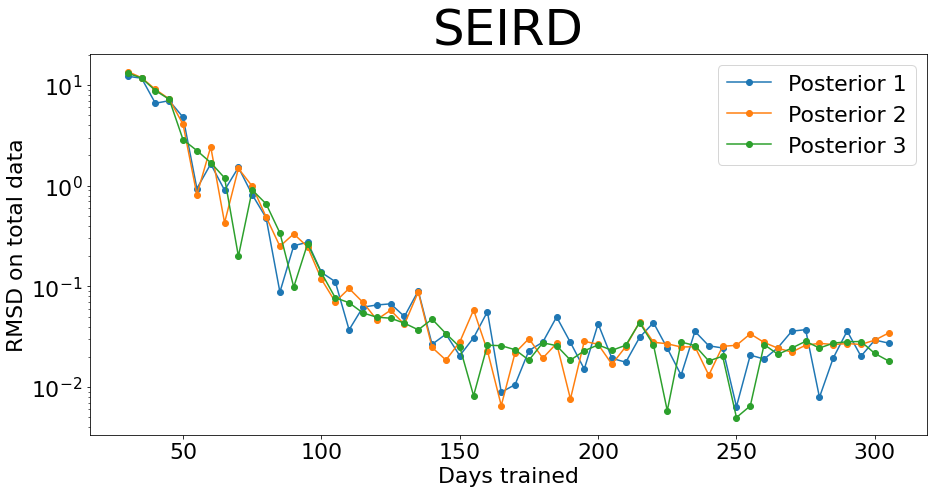

In [21]:
# plt.subplots_adjust(wspace=0.4, hspace=0.2)

rmsd = [rmsd_train, rmsd_val, rmsd_total]
rmsd_names = ["RMSD on train data", "RMSD on validation data", "RMSD on total data"]

for model_idx in range(len(models)):
    
    model = getattr(epi_mod, models[model_idx])
    
    for i in range(len(rmsd)):
        
        plt.figure(figsize=(15,7))
        
        for j in range(rmsd[i].shape[1]):
            
            plt.plot(days, rmsd[i][model_idx, j], "-o", label="Posterior %i"%(j+1))
            plt.legend()
            plt.xlabel("Days trained")
            plt.ylabel(rmsd_names[i])
            plt.yscale("log")
            plt.title(model.plot_name, fontsize=50)
    plt.show()

In [22]:
rmsd_train = np.zeros((len(models), n_post, n_days))
rmsd_val= np.zeros((len(models), n_post, n_days))
rmsd_total = np.zeros((len(models), n_post, n_days))

params = []

for model_idx in range(len(models)):
    
    model = getattr(epi_mod, models[model_idx])
    
    params.append(np.zeros((n_post, n_days, model.nparams)))
        
    for post in range(1, n_post+1):
            
        path = log_path+"Posterior%i/%s/%s/" % (post, location, models[model_idx])
        
        for days_idx in range(len(days_sets)):
            
            params[-1][post-1,days_idx,:] = np.genfromtxt(path+days_sets[days_idx]+"/best_params.txt")
            
            log_file = open(path+days_sets[days_idx]+"/%s_log.out"%model.name).read().split("\n")[:-1]
            
            for line in range(len(log_file)):

                if ("RMSD:" in log_file[line]):

                    rmsd_start_line = line
            
            rmsd_train[model_idx, post-1, days_idx] = float(log_file[rmsd_start_line].split(" ")[-1])
            rmsd_val[model_idx, post-1, days_idx] = float(log_file[rmsd_start_line+1].split(" ")[-1])
            rmsd_total[model_idx, post-1, days_idx] = float(log_file[rmsd_start_line+2].split(" ")[-1])

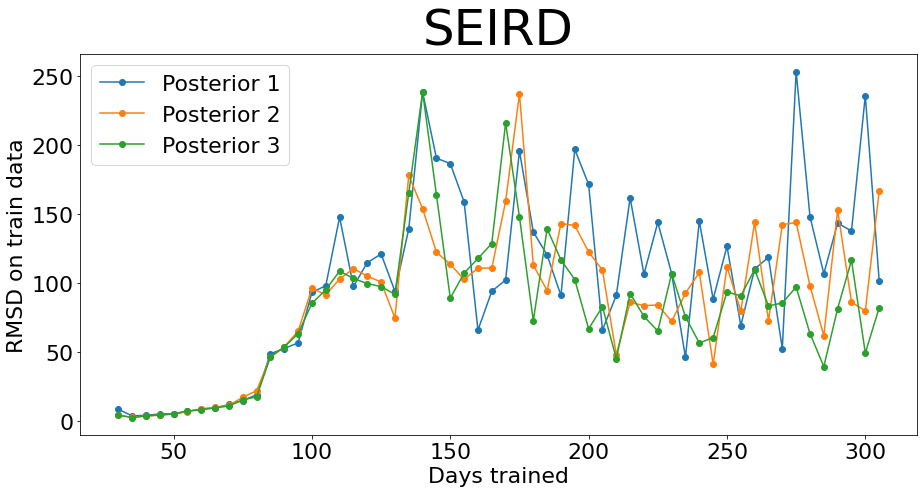

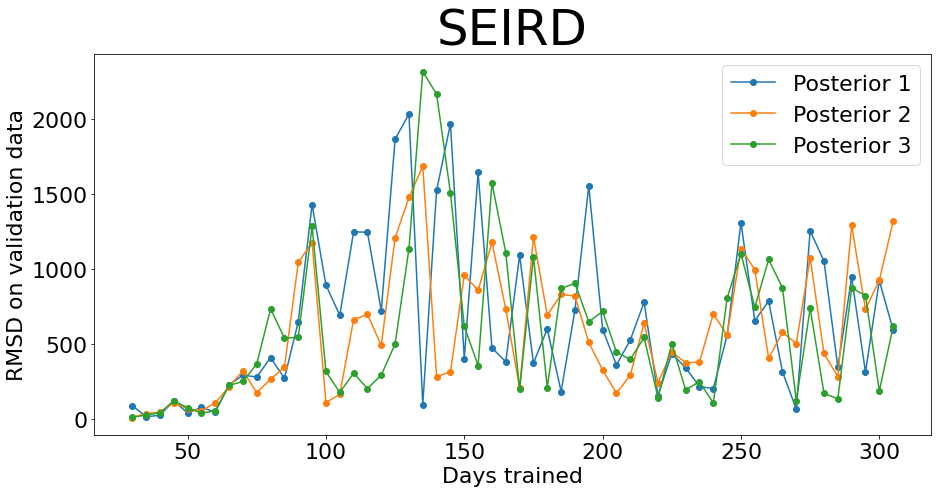

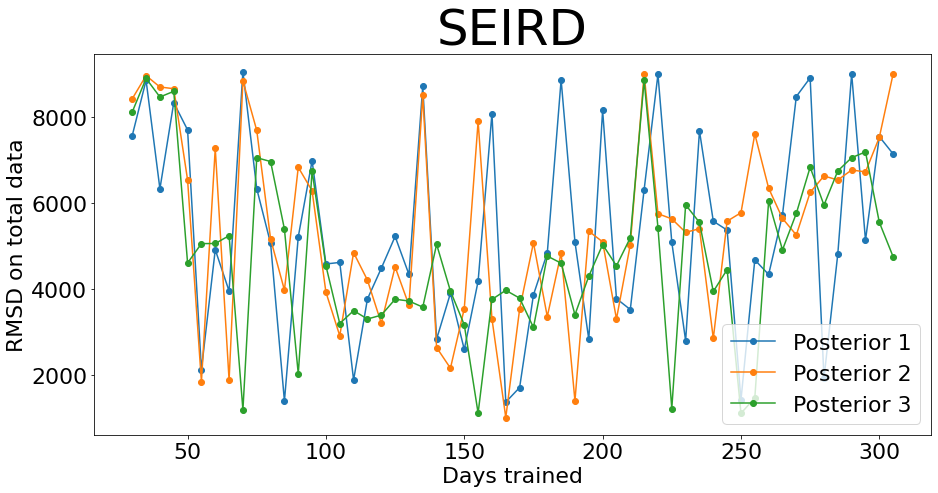

In [23]:
# plt.subplots_adjust(wspace=0.4, hspace=0.2)

rmsd = [rmsd_train, rmsd_val, rmsd_total]
rmsd_names = ["RMSD on train data", "RMSD on validation data", "RMSD on total data"]

for model_idx in range(len(models)):
    
    model = getattr(epi_mod, models[model_idx])
    
    for i in range(len(rmsd)):
        
        plt.figure(figsize=(15,7))
        
        for j in range(rmsd[i].shape[1]):
            
            plt.plot(days, rmsd[i][model_idx, j], "-o", label="Posterior %i"%(j+1))
            plt.legend()
            plt.xlabel("Days trained")
            plt.ylabel(rmsd_names[i])
            plt.title(model.plot_name, fontsize=50)
    plt.show()

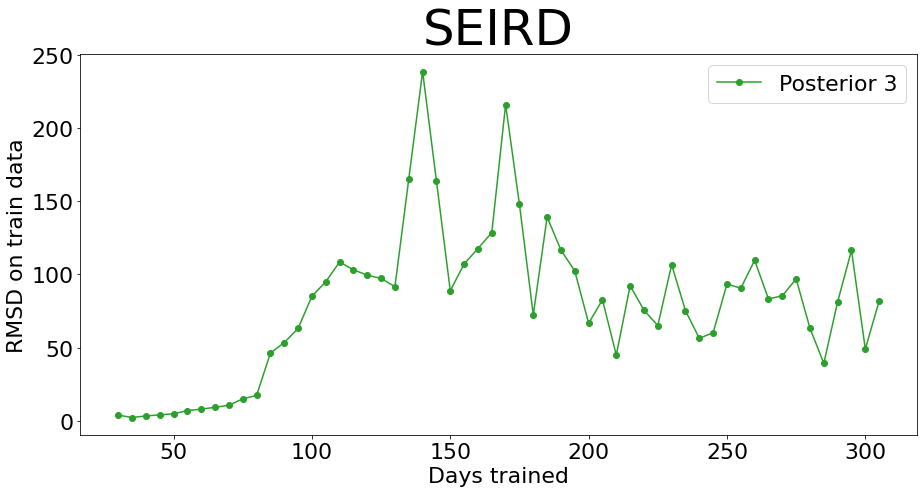

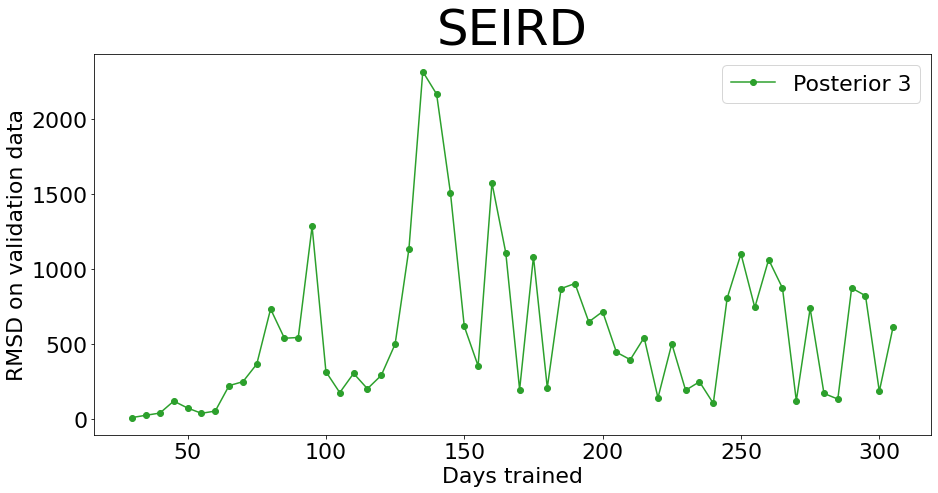

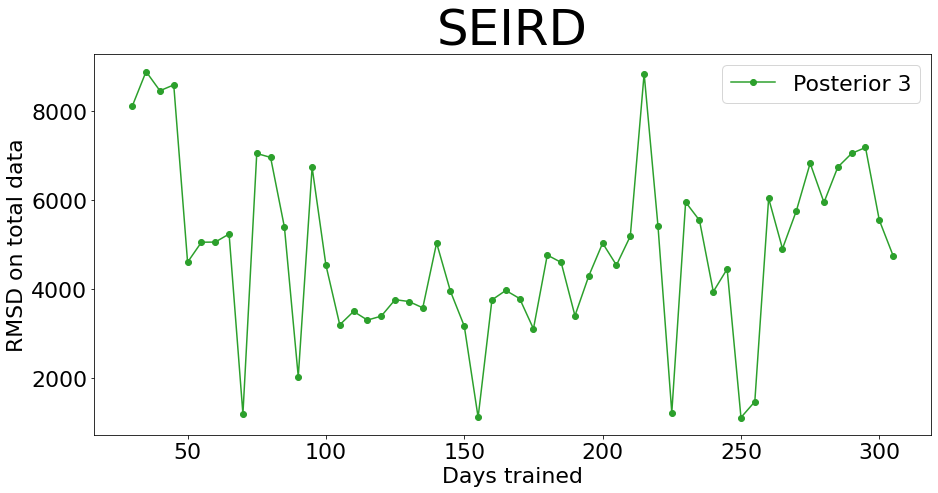

In [24]:
# plt.subplots_adjust(wspace=0.4, hspace=0.2)

rmsd = [rmsd_train, rmsd_val, rmsd_total]
rmsd_names = ["RMSD on train data", "RMSD on validation data", "RMSD on total data"]

for model_idx in range(len(models)):
    
    model = getattr(epi_mod, models[model_idx])
    
    for i in range(len(rmsd)):
        
        plt.figure(figsize=(15,7))
        plt.plot(days, rmsd[i][model_idx, j], "-o", c="C%s"%(rmsd[i].shape[1]-1), label="Posterior %i"%(j+1))
        plt.legend()
        plt.xlabel("Days trained")
        plt.ylabel(rmsd_names[i])
        plt.title(model.plot_name, fontsize=50)
        
    plt.show()

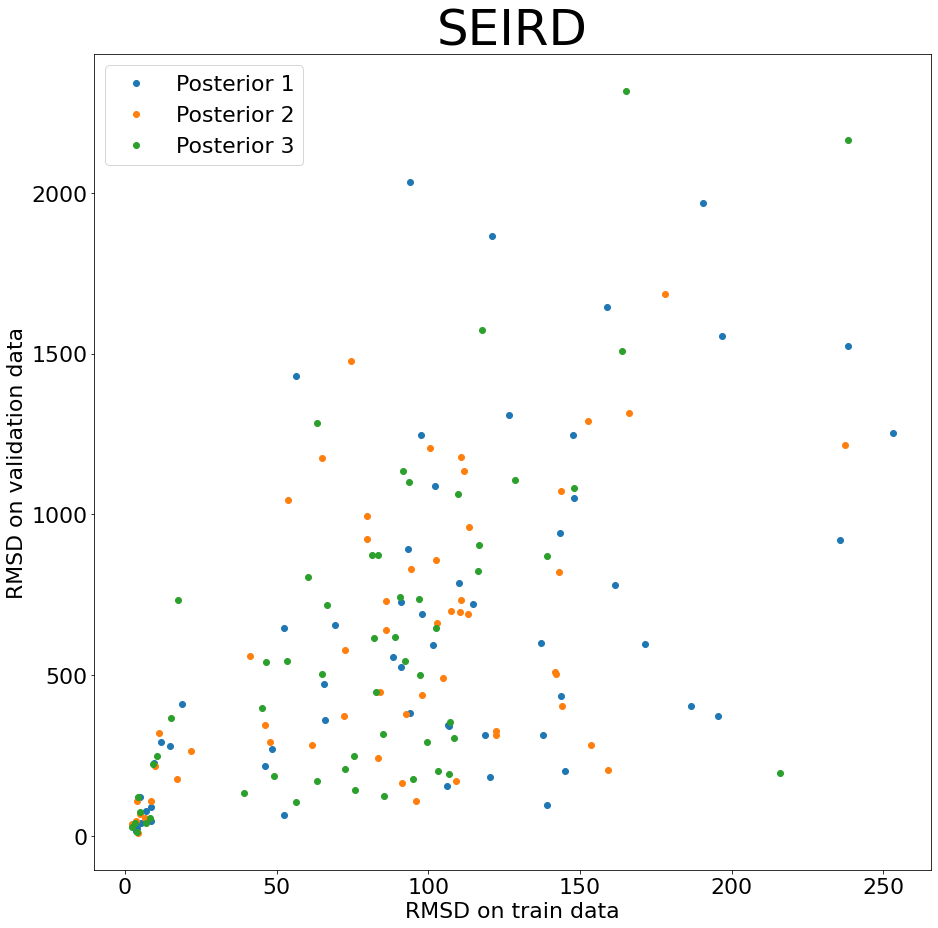

In [25]:
# plt.subplots_adjust(wspace=0.4, hspace=0.2)

rmsd = [rmsd_train, rmsd_val, rmsd_total]
rmsd_names = ["RMSD on train data", "RMSD on validation data", "RMSD on total data"]

for model_idx in range(len(models)):
    
    model = getattr(epi_mod, models[model_idx])
    
    plt.figure(figsize=(15,15))

    for j in range(rmsd[0].shape[1]):
        
        plt.plot(rmsd[0][model_idx, j], rmsd[1][model_idx, j], "o", label="Posterior %i"%(j+1))
        plt.legend()
        plt.xlabel(rmsd_names[0])
        plt.ylabel(rmsd_names[1])
        plt.title(model.plot_name, fontsize=50)
    plt.show()

In [30]:
from scipy.stats import pearsonr

print("RMSD on train and validation Pearson Correlations:")
print("Posterior 1:", pearsonr(rmsd[0][0,0], rmsd[1][0,0]))
print("Posterior 2:", pearsonr(rmsd[0][0,1], rmsd[1][0,1]))
print("Posterior 3:", pearsonr(rmsd[0][0,2], rmsd[1][0,2]))

RMSD on train and validation Pearson Correlations:
Posterior 1: (0.5443698831416297, 1.4448670087981613e-05)
Posterior 2: (0.5632544247361246, 6.203372374305623e-06)
Posterior 3: (0.6408359362311328, 1.0378583246655297e-07)
